<a href="https://colab.research.google.com/github/angelohafner/Python/blob/main/Back_to_back_Inrsuh_capacitores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cálculo da Corrente Back-to-Back em Bancos de Capacitores

## Introdução

O cálculo de corrente back-to-back em bancos de capacitores é uma parte importante do projeto e análise de sistemas de energia elétrica. Este cálculo é essencial para garantir a operação segura e eficiente de bancos de capacitores, especialmente em aplicações de correção de fator de potência e filtragem de harmônicas.

## O que é Corrente Back-to-Back?

A corrente back-to-back refere-se à corrente que flui entre dois bancos de capacitores quando estão conectados em paralelo e comutados simultaneamente. Este tipo de configuração é comum em sistemas de energia para melhorar a eficiência e a qualidade da energia.



In [108]:
import sympy as sp
import numpy as np
import plotly.graph_objects as go

In [109]:
s, t = sp.symbols("s t")
L, C, R, V = sp.symbols("L C R V", real=True, positive=True)

In [110]:
E = sp.sqrt(2) * V / s
Z = R + s*L + 1/(s*C)
I = E / Z
I_standard_form = I.apart(s)
I_standard_form

sqrt(2)*C*V/(C*L*s**2 + C*R*s + 1)

In [111]:
# Calculando os polos e zeros
polos = sp.roots(sp.denom(I_standard_form), s)
zeros = sp.roots(sp.numer(I_standard_form), s)
polos

{-R/(2*L) - sqrt(C*R**2 - 4*L)/(2*sqrt(C)*L): 1,
 -R/(2*L) + sqrt(C*R**2 - 4*L)/(2*sqrt(C)*L): 1}

Em Python, a expressão:

```python
{-R/(2*L) - sqrt(C*R**2 - 4*L)/(2*sqrt(C)*L): 1,
 -R/(2*L) + sqrt(C*R**2 - 4*L)/(2*sqrt(C)*L): 1}
```

representa um dicionário, onde:

- As **chaves** do dicionário são os valores dos polos da função de transferência.
- Os **valores** associados a cada chave representam a multiplicidade de cada polo.

Neste contexto específico:

1. **Chaves do Dicionário (Polos)**:
   - `-R/(2*L) - sqrt(C*R**2 - 4*L)/(2*sqrt(C)*L)`: Este é um polo da função de transferência. Ele é calculado com base nos parâmetros \( R \), \( L \) e \( C \). A expressão inclui uma raiz quadrada e representa uma das soluções da equação característica do denominador da função de transferência.
   - `-R/(2*L) + sqrt(C*R**2 - 4*L)/(2*sqrt(C)*L)`: Este é o outro polo da função de transferência, também dependente dos parâmetros \( R \), \( L \) e \( C \). Ele é semelhante ao primeiro polo, mas com um sinal oposto na parte da raiz quadrada.

2. **Valores do Dicionário (Multiplicidade dos Polos)**:
   - Ambos os polos têm um valor associado de `1`, indicando que cada um deles tem uma multiplicidade de 1. Isso significa que cada polo aparece uma única vez na função de transferência.

Resumindo, este dicionário está descrevendo os polos da função de transferência e a multiplicidade de cada um desses polos. Em termos de análise de sistemas de controle ou processamento de sinais, esses polos são críticos para entender a estabilidade e o comportamento do sistema descrito pela função de transferência.


In [112]:
i = sp.inverse_laplace_transform(I, s, t)
i.simplify()

2*sqrt(2)*sqrt(C)*V*exp(-R*t/(2*L))*sin(t*sqrt(-C*R**2 + 4*L)/(2*sqrt(C)*L))*Heaviside(t)/sqrt(-C*R**2 + 4*L)

## Começa a parte numérica

Expressão simbólica da corrente $i(t)$ contervida em uma função numpy `i_numerica`

In [113]:
i_numerica = sp.lambdify((t, L, C, R, V), i, 'numpy')

In [114]:
# fator de segurança
FC = 1.0
# quantidade de bancos em paralelo
nr_bancos = 5
# tensão fase-fase
V_ff = 23.1e3
# tensão fase neutro
V_fn = V_ff / np.sqrt(3)
# frequência fundamental
f_fund = 60
w_fund = 2*np.pi*f_fund
# potência trifásica do banco
Q_3f = 30e6 * np.ones(nr_bancos, dtype=float)
Q_1f = Q_3f / 3
# corrente de fase dos estágios do banco em Y
I_fn =  Q_1f / V_fn
formatted_I_fn = ", ".join(f"{item:.1f}" for item in I_fn)
print(f"Corrente de fase dos estágios do banco em Y = [{formatted_I_fn}] A")

Corrente de fase dos estágios do banco em Y = [749.8, 749.8, 749.8, 749.8, 749.8] A


In [115]:
# reatância e capacitância dos estágios
X = V_fn / I_fn
C = 1 / ( w_fund * X )
formatted_C = ", ".join(f"{item:.1f}" for item in C*1e6)
print(f"Corrente de fase dos estágios do banco em Y = [{formatted_C}] uF")

Corrente de fase dos estágios do banco em Y = [149.1, 149.1, 149.1, 149.1, 149.1] uF


In [116]:
# Henries por metro da barra
L_unit_barra = 0.0329e-6 * np.ones(nr_bancos, dtype=float)
# Henries por metro do cabo
L_unit_cabo  = 0.396e-6  * np.zeros(nr_bancos, dtype=float)

# comprimento da barra
comp_barra = 30.0 * np.zeros(nr_bancos, dtype=float)
# comprimento do cabo
comp_cabo  = 20.0 * np.ones(nr_bancos, dtype=float)

# indutância série da barra e do cabo
L_barra_mais_cabo = comp_barra * L_unit_barra + comp_cabo * L_unit_cabo

In [117]:
# alguns capacitores tem uma pequena indutância em série de fábrica
L_capacitor = 5e-6 * np.ones(nr_bancos, dtype=float)
# indutor a ser colocado em série com o estágio capacitivo
L_reator = 200e-6 *np.ones(nr_bancos, dtype=float)

In [118]:
# indutância total entre dois estágios de capacitor
L = L_barra_mais_cabo + L_capacitor + L_reator
print(f"Indutância total entre dois estágios de capacitor = {1e6*L} uH")

Indutância total entre dois estágios de capacitor = [205. 205. 205. 205. 205.] uH


In [119]:
from IPython.core.display import Latex
# imagiando todos os "n-1" capacitores ligados e entrando o capacitor "0"
# capacitância combinada dos "n-1" capacitores ligados
C_paralelos = np.sum(C[1:])
# associando estes "n-1" em série com o capacitor a ser acionado
den_C = 1/C[0] + 1/C_paralelos
C_eq = 1/den_C

# indutância combinada dos "n-1" capacitores ligados
L_paralelos =  1 / np.sum( 1 / L[1:] )
# associando estes "n-1" em série com a indutância do capacitor a ser acionado
L_eq = L[0] + L_paralelos
# resistência imaginada do sistema
R_eq = 0.1

print(f"Capacitância dos 'n-1' capacitores em paralelo = {1e6*C_paralelos:.1f} uF")
print(f"Capacitância do capacitor a ser acionado       = {1e6*C[0]:.1f} uF")
print(f"Capacitância C[1:] série com C[0]              = {1e6*C_eq:.1f} uF")
print("")
print(f"Indutância combinada dos 'n-1' capacitores ligados = {1e6*L_paralelos:.1f} uH")
print(f"Indutância do capacitor a ser acionado             = {1e6*L[0]:.1f} uH")
print(f"Indutância L[1:] série com L[0]                    = {1e6*L_eq:.1f} uH")

Capacitância dos 'n-1' capacitores em paralelo = 596.5 uF
Capacitância do capacitor a ser acionado       = 149.1 uF
Capacitância C[1:] série com C[0]              = 119.3 uF

Indutância combinada dos 'n-1' capacitores ligados = 51.3 uH
Indutância do capacitor a ser acionado             = 205.0 uH
Indutância L[1:] série com L[0]                    = 256.2 uH


In [120]:
t_num = np.linspace(0, 2/60, 2*(2**12) )
i_inrush = i_numerica(t_num, L_eq, C_eq, R_eq, 23.1e3/np.sqrt(3))

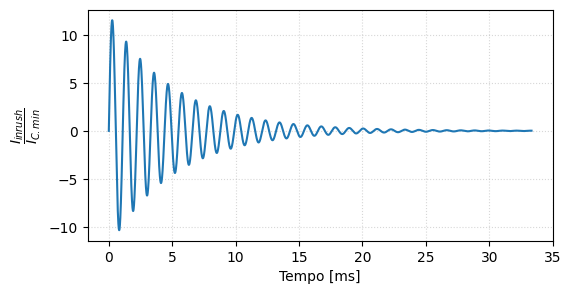

In [121]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(1e3*t_num, i_inrush/(np.sqrt(2)*np.min(I_fn)))
ax.grid(ls=":", alpha=0.5)
ax.set_ylabel(r'$\dfrac{I_{inrush}}{I_{C.min}}$')
ax.set_xlabel(r'Tempo [ms]')
fig.show()